In [ ]:
from typing import Dict

import numpy as np
import pandas as pd
from products.plot_settings import  NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME,MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr
from xarray.groupers import BinGrouper

wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analysis_type = "confusion_table"

analyses_dict_confusion = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

def sel_evaluation_domain(analyses_dict: Dict[str, xr.Dataset]) ->Dict[str, xr.Dataset]:

    selection_dict={}
    for k, v in analyses_dict.items():
        if 'sensor_zenith_bins' not in v.sizes:
            selection_dict .update({
                k: v.expand_dims({'sensor_zenith_bins': 5})
                })
        else:
            selection_dict.update({k:v})

    selection_dict = {
        k: v.sel(
            time=slice("2023-12", "2024-06"),
            altitude_bins=slice(900, None),
            ref_bins=slice(0, 101),
            slope_bins=slice(None, 60),
            sensor_zenith_bins=slice(None,80)
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.assign_coords(
            {
                "aspect_bins": pd.CategoricalIndex(
                    data=EvaluationVsHighResBase.aspect_bins().labels,
                    categories=EvaluationVsHighResBase.aspect_bins().labels,
                    ordered=True,
                ),
                "forest_mask_bins": ["Open", "Forest"],
                "slope_bins": np.array(["[0-10]", "[11-30]", ">30"], dtype=str),
                "sensor_zenith_bins": np.array(["[0-15]", "[15-30]", "[30-45]", "[45-60]",">60"], dtype=str),
            }
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.rename(
            {"aspect_bins": "Aspect", "forest_mask_bins": "Landcover", "slope_bins": "Slope [°]", "sensor_zenith_bins": "View Zenith Angle [°]"}
        )
        for k, v in selection_dict.items()
    }

    return selection_dict



metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)
metrics_dict_conf = {k:v.groupby(ref_bins=BinGrouper(bins=[-1,0,99,100], labels=["0", "[1-99]", "100"])).sum().rename({"ref_bins_bins": "Ref FSC [%]"}) for k,v in metrics_dict_conf.items()}
metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')).assign_coords(ref_bins=["0", "[1-25]", "[26-50]","[51-75]", "[75-99]", "100"]).rename({"ref_bins": "Ref FSC [%]"}) for k,v in metrics_dict_unc.items()}

/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  func(*args, **kwargs)
/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)


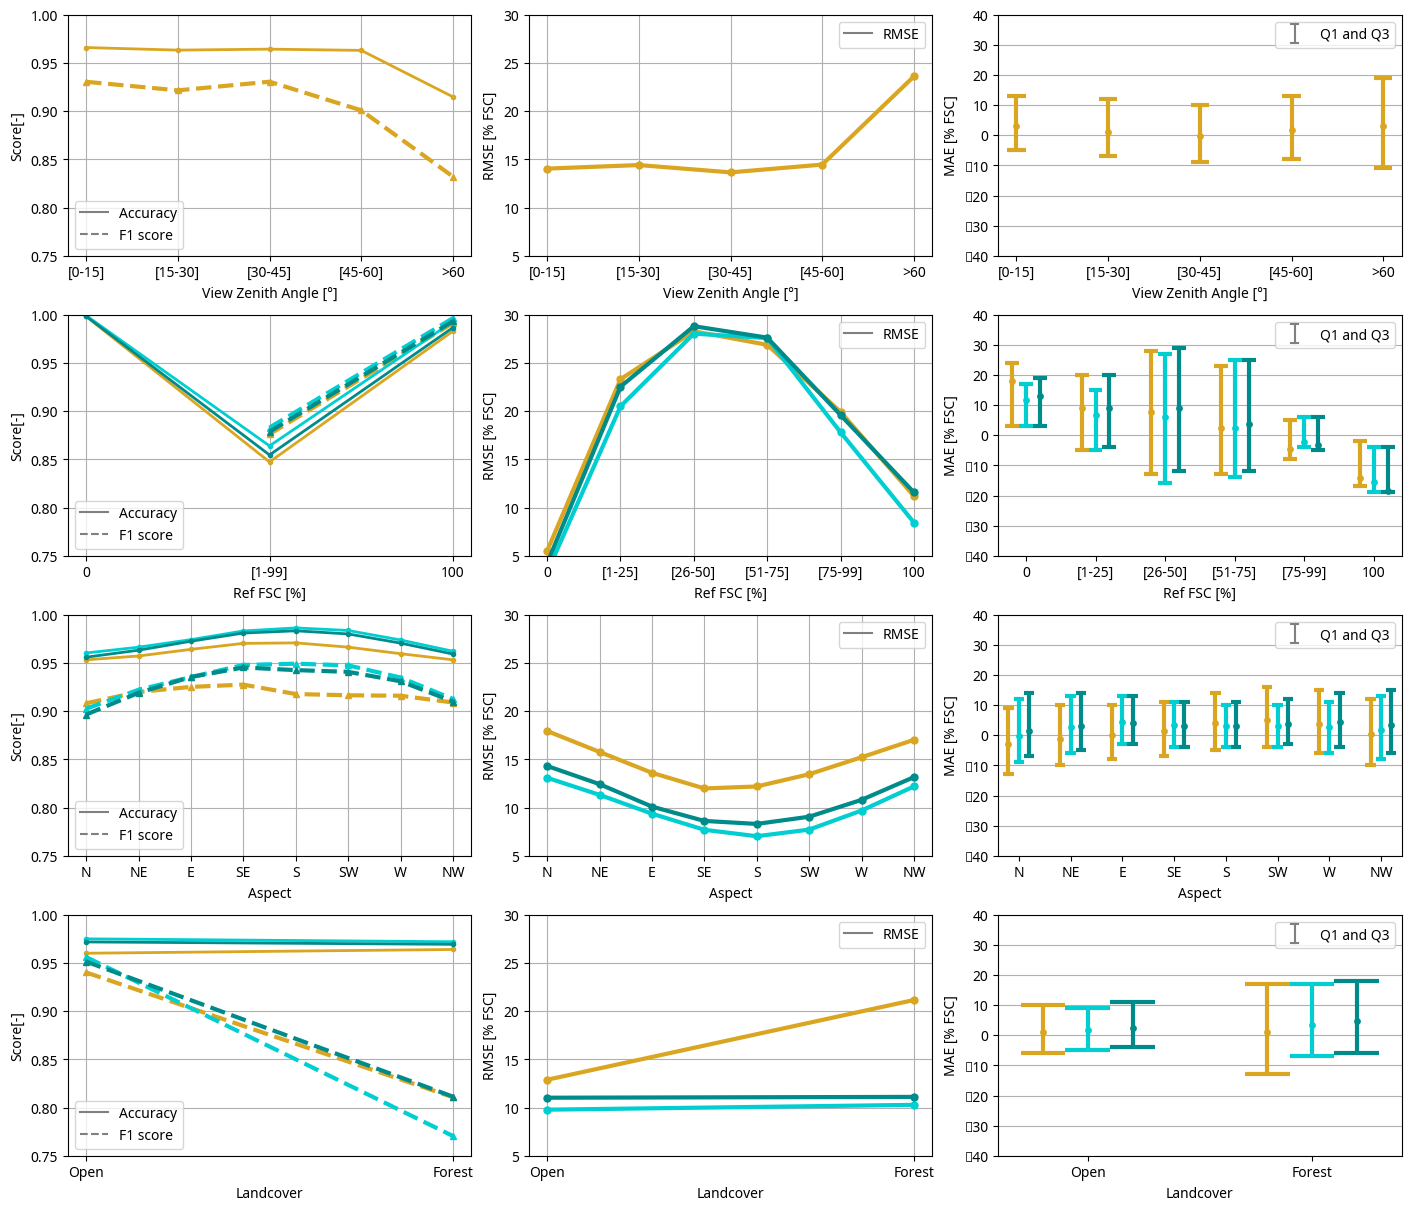

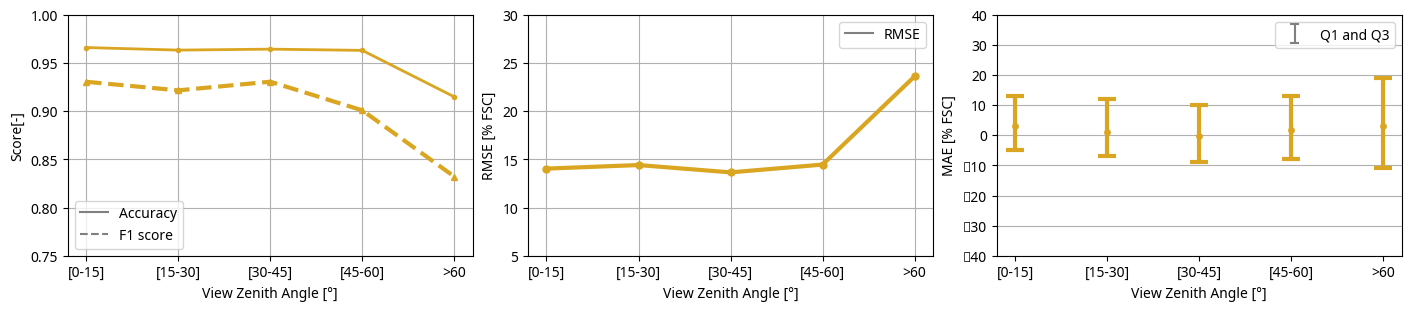

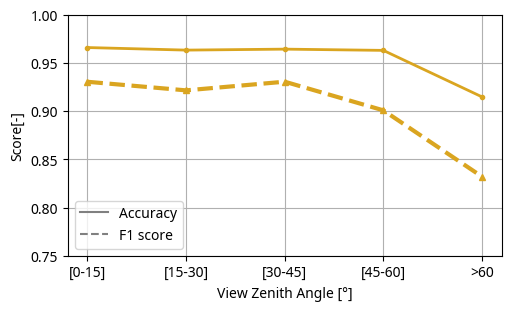

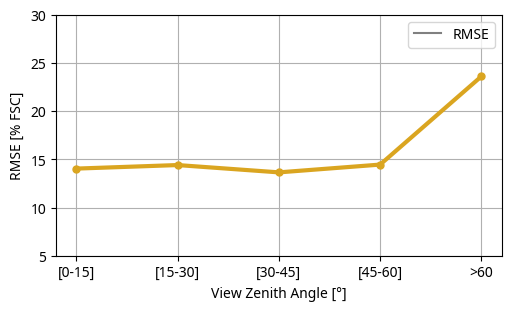

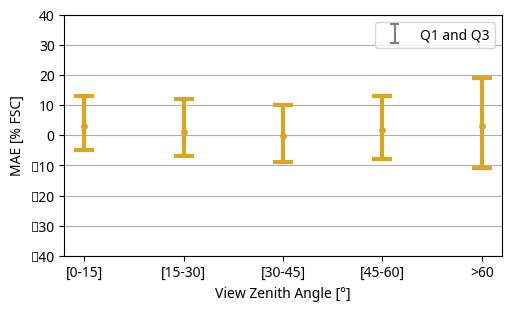

In [17]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import histograms_to_distribution, line_plot_rmse, plot_custom_spans
from postprocess.skill_scores import line_plot_accuracy_f1_score
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches


def plot_product_legend(metrics_dict: Dict[str, xr.Dataset],legend_ax: Axes):
    custom_leg = [
            mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
            for product_name in metrics_dict
        ]
        
    product_legend =legend_ax.legend(handles=custom_leg, loc='best')
    legend_ax.add_artist(product_legend)

def plot_one_var_analysis(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], analysis_var:str, axs: List[Axes]):
    if analysis_var=="View Zenith Angle [°]":
        line_plot_accuracy_f1_score(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var,ax=axs[0])
        plot_custom_spans(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var, ax=axs[2])
        line_plot_rmse(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var,ax=axs[1])
    else:
        line_plot_accuracy_f1_score(metrics_dict_conf, analysis_var=analysis_var,ax=axs[0])
        line_plot_rmse(metrics_dict_unc, analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(metrics_dict_unc=metrics_dict_unc, analysis_var=analysis_var, ax=axs[2])
def plot_grid(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},
                                  metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},
                                  analysis_var=var,
                                  axs=axs[i])
        else:
            plot_one_var_analysis(metrics_dict_conf, metrics_dict_unc, var,axs[i])


plt.style.use('default')
plt.rcParams["font.family"] = "Noto Sans"
params = ["View Zenith Angle [°]", "Ref FSC [%]", "Aspect", "Landcover"] 
fig, axs = plt.subplots(len(params), 3, figsize=(14,3  * len(params)), layout="constrained")
plot_grid(metrics_dict_conf=metrics_dict_conf, metrics_dict_unc=metrics_dict_unc, params_list=params, axs=axs)
fig, axs = plt.subplots(1, 3, figsize=(14,3  ), layout="constrained")
plot_one_var_analysis(metrics_dict_conf=metrics_dict_conf, metrics_dict_unc=metrics_dict_unc, analysis_var=params[0], axs=axs)
fig, axs = plt.subplots( figsize=(5,3 ), layout="constrained")
line_plot_accuracy_f1_score(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},analysis_var="View Zenith Angle [°]", ax=axs)
fig, axs = plt.subplots( figsize=(5,3 ), layout="constrained")
line_plot_rmse(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},analysis_var="View Zenith Angle [°]", ax=axs)
fig, axs = plt.subplots( figsize=(5,3 ), layout="constrained")
plot_custom_spans(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},analysis_var="View Zenith Angle [°]", ax=axs)
# fig.patch.set_alpha(0.0)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/evaluation_multiplot_ref_fsc_vza.png', format='png')

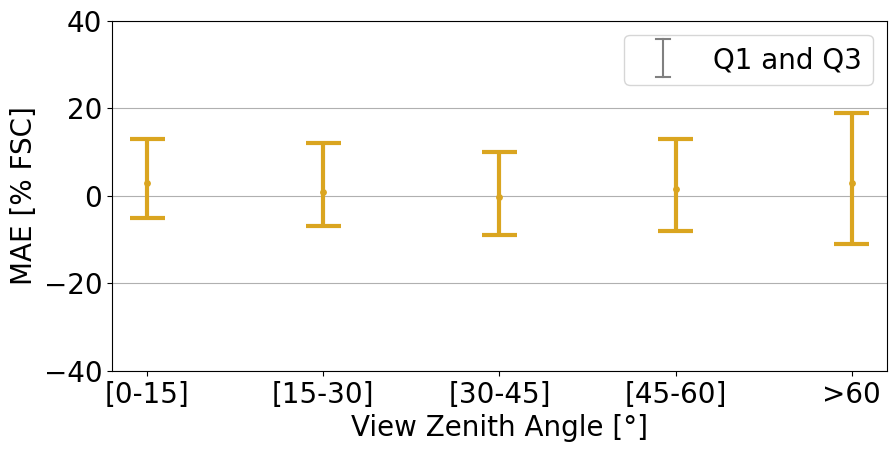

In [48]:
import matplotlib
plt.rcParams["font.family"] = "Noto Sans"
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(10,5))
plt.subplots_adjust(bottom=0.18)


plot_custom_spans(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},analysis_var='View Zenith Angle [°]',ax=axs)
fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/evaluation_vza_spans.png', format='png')

In [1]:
import numpy as np

from products.plot_settings import NASA_L3_MULTIPLATFORM_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME, MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analyses_dict_completeness = {

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform.nc",
        decode_cf=True,
    ),

}

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

<Figure size 640x480 with 0 Axes>

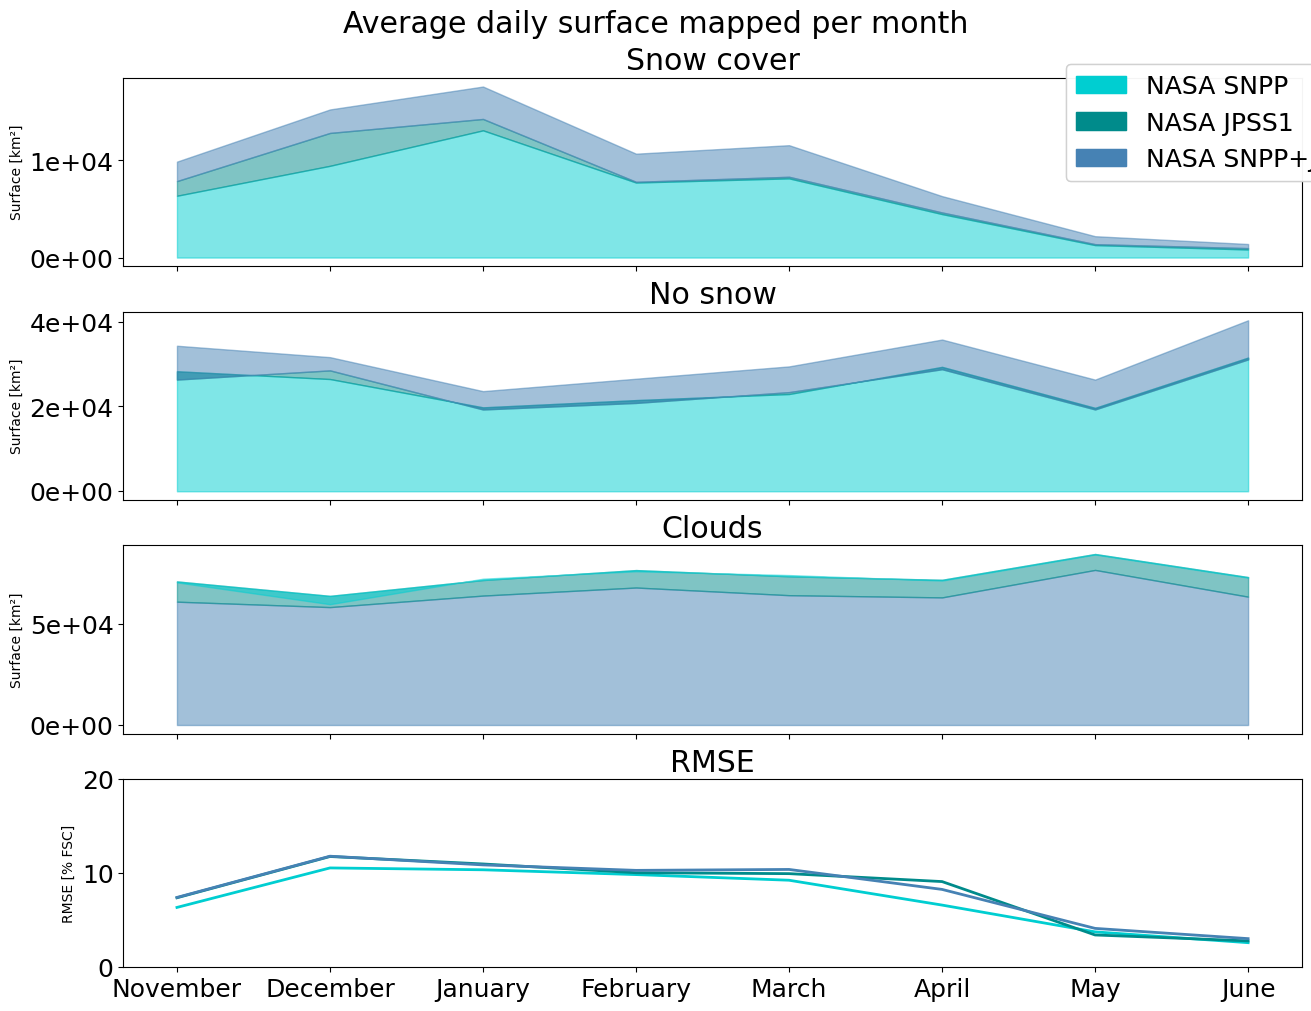

In [2]:
from postprocess.class_distribution import annual_area_fancy_plot
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["font.family"] = "Noto Sans"
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True, layout="constrained")
fig.suptitle("Average daily surface mapped per month")
annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc, axs=axs)
# fig.patch.set_alpha(0.0)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/area_composite.png', format='png')

In [ ]:
# Compute percentage per class
# cn = 'no_snow'
100*(metrics_dict_completeness['nasa_l3_multiplatform'].data_vars['surface'].sel(class_name=cn).sum()/metrics_dict_completeness['nasa_l3_snpp'].data_vars['surface'].sel(class_name=cn).sum() -1)

<xarray.DataArray 'surface' ()> Size: 8B
array(26.28741138)
Coordinates:
    class_name  <U10 40B 'no_snow'

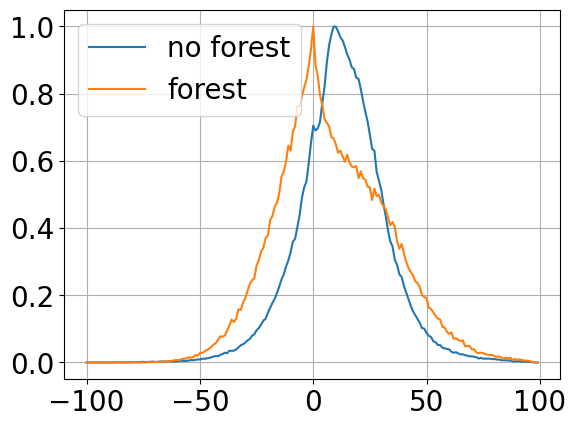

In [ ]:
# Study forest vs no forest scatter

# Sum of the diagonals of the diagram
reduced = (
    nasa_l3_snpp_metrics_ds.sel(
        forest_mask_bins=['no_forest'],
        ref_bins=slice(1, 98),
        test_bins=slice(1, 98),
    )
    .sum(dim=("forest_mask_bins", "time"))
    .data_vars["n_occurrences"]
)
no_forest = np.array([np.trace(np.flip(reduced.values),i) for i in range(-100,100)])
reduced = (
    nasa_l3_snpp_metrics_ds.sel(
        forest_mask_bins=['forest'],
        ref_bins=slice(1, 98),
        test_bins=slice(1, 98),
    )
    .sum(dim=("forest_mask_bins", "time"))
    .data_vars["n_occurrences"]
)
forest = np.array([np.trace(np.flip(reduced.values),i) for i in range(-100,100)])
fig, ax = plt.subplots()
ax.plot(np.arange(-100,100),no_forest/no_forest.max(),label='no forest')
ax.plot(np.arange(-100,100),forest/forest.max(),label= 'forest')
ax.legend()
ax.grid()

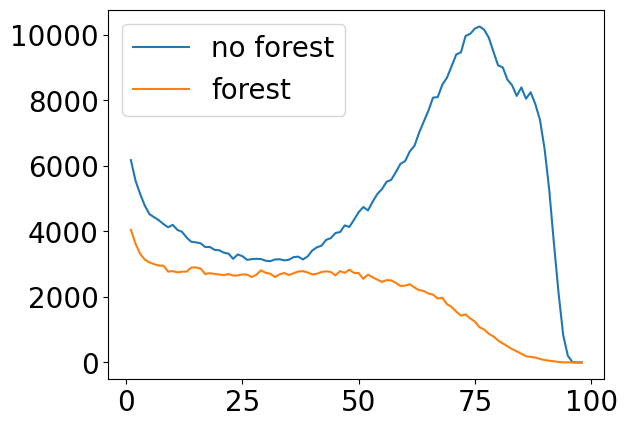

In [ ]:
# NDSI wise distribution
fig, ax = plt.subplots()
reduced = (
    nasa_l3_snpp_metrics_ds.sel(
        ref_bins=slice(1, 99),
        forest_mask_bins=['no_forest'],
        test_bins=slice(1, 99),
    )
    .sum(dim=("forest_mask_bins", "time"))
    .data_vars["n_occurrences"]
)
ax.plot(reduced.test_bins.values, reduced.sel(test_bins=slice(1,99)).sum(dim='ref_bins'),label='no forest')
reduced = (
    nasa_l3_snpp_metrics_ds.sel(
        ref_bins=slice(1, 99),
        forest_mask_bins=['forest'],
        test_bins=slice(1, 99),
    )
    .sum(dim=("forest_mask_bins", "time"))
    .data_vars["n_occurrences"]
)
ax.plot(reduced.test_bins.values, reduced.sel(test_bins=slice(1,99)).sum(dim='ref_bins'),label='forest')
ax.legend()

<Figure size 640x480 with 0 Axes>

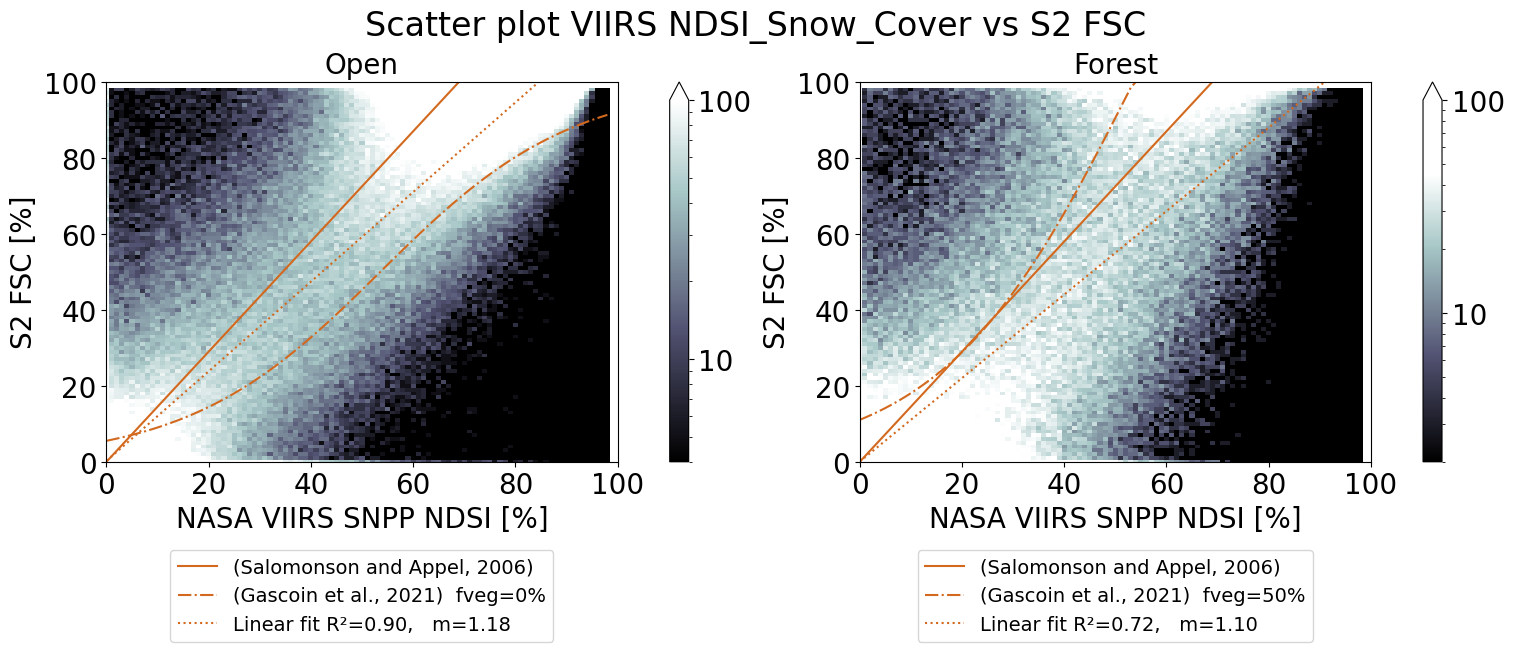

In [4]:

### NDSI-FSC regression
from matplotlib.axes import Axes
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
nasa_l3_snpp_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_NDSI_vs_s2_theia_FSC.nc", decode_cf=True
)
nasa_l3_snpp_metrics_ds = nasa_l3_snpp_metrics_ds.where(nasa_l3_snpp_metrics_ds > 0, drop=True)

plt.rcParams["font.family"] = "Noto Sans"
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.subplots_adjust(bottom=0.18)
fig, ax = plt.subplots(1,2, figsize=(15, 6), sharex=True, layout="constrained")
fig.suptitle("Scatter plot NASA VNP10 NDSI vs S2 FSC")




# ax[0].set_facecolor('#222')
FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            ref_bins=slice(0, 98),
            forest_mask_bins=[fore],
            test_bins=slice(0, 98),
        )
        .sum(dim=("forest_mask_bins", "time"))
        .data_vars["n_occurrences"]
    )
    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Gascoin et al., 2021)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=n_min,
        smoothing_window_size=0,
    )
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [%]")
    ax[i].set_xlabel("NASA VIIRS SNPP NDSI [%]")
    ax[i].set_title(FOREST_TITLE[fore], fontsize=20)


plt.show()

fig.patch.set_alpha(0.0)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/scatter.png', format='png',bbox_inches='tight')

/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

meteofrance_synopsis NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_snpp NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_jpss1 NW


/tmp/ipykernel_27950/3067715573.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(None,)

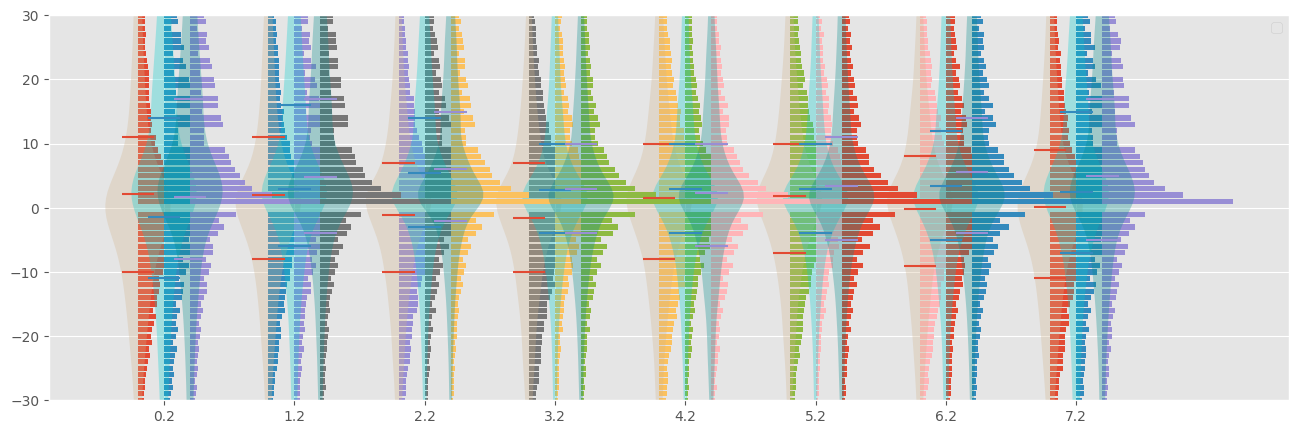

In [143]:
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for i,value in enumerate(metrics_dict[product_name].coords[analysis_var].values):
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value}).drop_sel(biais_bins=[0])
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))
            red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
            ax.barh(red.biais_bins,width=red.n_occurrences/red.n_occurrences.max(),left=ticks[i])

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs,
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )


        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,1, figsize=(16, 5))
# figs.style.use('ggplot')
# [axs[0].set_ylim(-50,50) for ax in axs]
axs.set_ylim(-30,30)
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='aspect_bins', ax=axs,showextrema=False,points=200,showmeans=True),#quantiles=[[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9]])
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=200,bw_method=0.5,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )